In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np

# Add the parent directory to sys.path so Python can find the files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from EKI.eki import *
from EKI.stopping_rules import *
from EKI.uq import *
from ForwardModels.models import *
from Utils.tools import *
from Mala.mala import *

In [3]:
D = 10
L = 2 * jnp.pi
h = (2 * jnp.pi) / D
ones_mat = jnp.ones((D + 1, D + 1))
delta_h = compute_second_order_diff(D, h)
init_mean = jnp.zeros(D + 1)
delta = 1e2
gamma = 1 / (2 * np.sqrt(h))

sqrt_covar = gamma * jnp.linalg.inv((delta * ones_mat / (D + 1)) - delta_h)

In [4]:
rng_key = random.PRNGKey(0)

ensemble = random.normal(rng_key, shape=(D + 1, 100))

ensemble = init_mean[:, jnp.newaxis] + jnp.dot(sqrt_covar, ensemble)

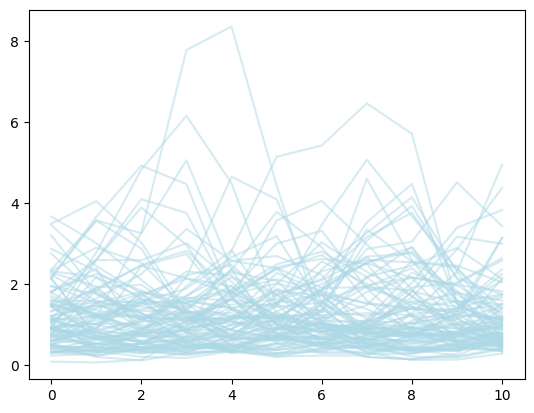

In [5]:
plt.plot(jnp.exp(ensemble), color="lightblue", alpha=0.5)
plt.show()

In [6]:
def run(
    f0,
    g_array,
    plot,
    h,
    dim_parameters,
    dim_observations,
    num_particles,
    noise_level=1e-6,
):
    """Run a simple EKI example."""
    # Set random seed for reproducibility
    key = random.PRNGKey(42)

    forward_model = Schroedinger(dim_parameters, dim_observations, f0, g_array, plot)

    y_true = forward_model.evaluate_single(f0)  # (dim_parms, )

    # Add noise to observations
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise
    # plt.plot(i_array, f0)
    # plt.plot(i_array, y_true)
    # plt.show()
    ones_mat = jnp.ones((dim_parameters + 1, dim_parameters + 1))
    delta_h = compute_second_order_diff(dim_parameters, h)
    init_mean = jnp.zeros(dim_parameters + 1)
    delta = 1e2
    gamma = 1 / (2 * jnp.sqrt(h))

    sqrt_covar = gamma * jnp.linalg.inv((delta * ones_mat / (D + 1)) - delta_h)

    prior_cov = sqrt_covar
    # Initialize EKI solver
    eki = EKI(
        forward_model=forward_model,
        observations=observations,
        dim_parameters=dim_parameters,
        num_particles=num_particles,
        init_covariance=prior_cov,
        init_mean=init_mean,
        noise_level=noise_level,
        time_interval=(1, 200, 200),  # (start, end, max_steps)
        rng_key=key,
    )

    # Create stopping rule: Discrepancy principle
    stopping_rule = DiscrepancyPrinciple(
        effective_dim=dim_observations,
        tolerance=noise_level,
        kappa=0.5,
        max_iterations=100,
    )

    # Run the algorithm with early stopping
    results = eki.fit(stopping_rule=stopping_rule)

    # Print results
    print(f"\nAlgorithm converged: {results['converged']}")
    print(f"Stopping time: {results['stopping_time']}")
    print(f"Final residual: {results['final_residual']:.6f}")

    return results

In [48]:
# global parameters
dim_parameters = 100
dim_observations = 100
plot = False
num_particles = 200

noise_levels = [1e-2, 1e-4, 1e-6, 1e-8]
print(noise_levels)

[0.01, 0.0001, 1e-06, 1e-08]


In [8]:
L = 2 * jnp.pi
h = (2 * jnp.pi) / dim_parameters
x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
f0 = jnp.exp(0.5 * jnp.sin(x_array))
g_array = (
    jnp.exp(-((x_array - L / 2) ** 2) / 10)
    - jnp.exp(-((x_array - L / 2) ** 2) / 10).mean()
)

In [49]:
results_list = []
for noise_level in noise_levels:
    results = run(
        f0,
        g_array,
        plot,
        h,
        dim_parameters,
        dim_observations,
        num_particles,
        noise_level,
    )
    results_list.append(results)

nonlinear
norm ensemble 203.33224
converged

Algorithm converged: True
Stopping time: 0
Final residual: 0.139877
nonlinear
norm ensemble 203.33224
norm ensemble 203.33224
norm ensemble 203.33224
norm cross_cov 2.4441943
124.09997
norm ensemble 187.81847
norm ensemble 187.81847
norm cross_cov 0.6287697
96.21166
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.019093
nonlinear
norm ensemble 203.33224
norm ensemble 203.33224
norm ensemble 203.33224
norm cross_cov 2.4441943
502.56042
norm ensemble 186.62724
norm ensemble 186.62724
norm cross_cov 0.67205584
433.20612
norm ensemble 172.80772
norm ensemble 172.80772
norm cross_cov 0.17356077
327.78854
norm ensemble 158.99629
norm ensemble 158.99629
norm cross_cov 0.06581503
256.47507
norm ensemble 164.9788
norm ensemble 164.9788
norm cross_cov 0.018395064
199.57918
norm ensemble 158.03029
norm ensemble 158.03029
norm cross_cov 0.005934949
163.48462
norm ensemble 160.87292
norm ensemble 160.87292
norm cross_cov 0.0015813

stopping time 1
stopping time 3
stopping time 9
stopping time 9


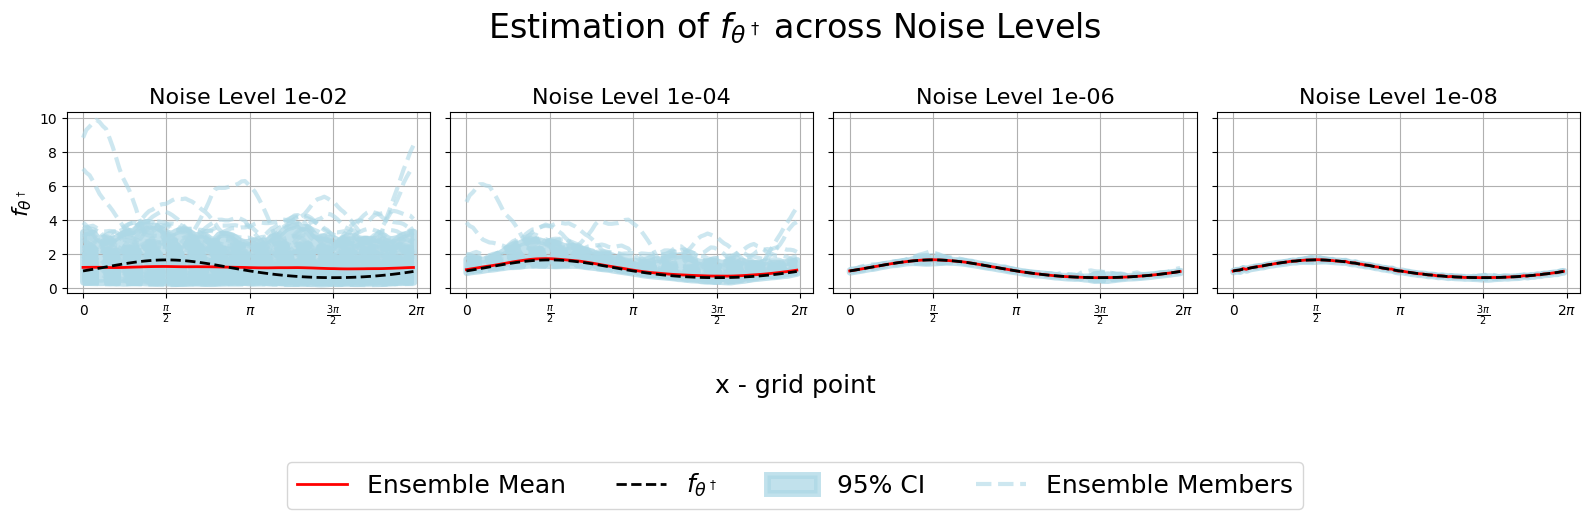

In [50]:
import matplotlib.pyplot as plt

x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
q = jnp.array([0.025, 0.975])

num_levels = len(results_list)  # number of noise levels

fig, axes = plt.subplots(
    1,  # single row
    num_levels,
    figsize=(4 * num_levels, 4),
    sharex=True,
    sharey=True,
)

# Handle the case where there's only one noise level
if num_levels == 1:
    axes = [axes]

# Loop over noise levels (columns)
for col_idx, results in enumerate(results_list):
    ax = axes[col_idx]
    print("stopping time", len(results["ensemble_history"]))
    hat_coefs_f0_ensemble = results["ensemble_history"][-1]

    # Plot individual ensemble members
    ensemble_members_handle = ax.plot(
        x_array,
        hat_coefs_f0_ensemble,
        color="lightblue",
        linestyle="dashed",
        alpha=0.6,
        linewidth=3,
    )

    # Ensemble mean
    (ensemble_mean_handle,) = ax.plot(
        x_array,
        jnp.mean(hat_coefs_f0_ensemble, axis=1),
        color="red",
        linewidth=2,
        label="ensemble mean",
    )
    mean = jnp.mean(hat_coefs_f0_ensemble, axis=1)
    diff = jnp.linalg.norm(f0 - mean)
    # print(diff)
    # True f0
    (f0_handle,) = ax.plot(
        x_array,
        f0,
        color="black",
        label=r"$\theta^\dagger$",
        linestyle="dashed",
        linewidth=2,
    )

    # Quantiles
    quantiles = jnp.quantile(hat_coefs_f0_ensemble, q, axis=1)
    fill_handle = ax.fill_between(
        x_array,
        quantiles[0],
        quantiles[1],
        color="lightblue",
        alpha=0.75,
        label="95% CI",
        linewidth=5,
    )

    # Set title for each subplot
    ax.set_title(f"Noise Level {noise_levels[col_idx]:.0e}", fontsize=16)
    ax.set_xticks([0, jnp.pi / 2, jnp.pi, 3 * jnp.pi / 2, 2 * jnp.pi])
    ax.set_xticklabels(
        ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    )
    ax.grid(True)

# Set ylabel for the single row
axes[0].set_ylabel(r"$f_{\theta^\dagger}$", fontsize=16)

fig.supxlabel("x - grid point", fontsize=18)

# Common legend
handles = [ensemble_mean_handle, f0_handle, fill_handle, ensemble_members_handle[0]]
labels = ["Ensemble Mean", r"$f_{\theta^\dagger}$", "95% CI", "Ensemble Members"]
fig.legend(
    handles, labels, loc="lower center", ncol=4, fontsize=18, bbox_to_anchor=(0.5, -0.3)
)

# Main title
fig.suptitle(r"Estimation of $f_{\theta^\dagger}$ across Noise Levels", fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [11]:
time_interval = np.arange(1, 200, 1)
taus = []
for results in results_list:
    stopping_index = results["stopping_time"]
    stopping_time = time_interval[stopping_index]
    print("stopping time", stopping_time)
    taus.append(stopping_time)

stopping time 1
stopping time 3
stopping time 7
stopping time 8


In [12]:
import numpyro

import numpyro.distributions as dist

In [19]:
forward_model = Schroedinger(dim_parameters, dim_observations, f0, g_array, plot)


def posterior(dim_parameters, sigma, prior_cov, y=None):
    theta = numpyro.sample(
        "theta",
        dist.MultivariateNormal(
            loc=jnp.zeros(dim_parameters + 1), covariance_matrix=prior_cov
        ),
    )

    f_theta = jnp.exp(theta)

    uf = forward_model.evaluate_single(f_theta)
    noise_matrix = jnp.eye(dim_parameters + 1) * sigma
    numpyro.sample("obs", dist.MultivariateNormal(uf, noise_matrix), obs=y)

In [14]:
from jax import random

from numpyro.infer import MCMC, NUTS

In [15]:
# key = random.PRNGKey(42)
#
# forward_model = Schroedinger(dim_parameters, dim_observations, f0, g_array, plot)
#
# y_true = forward_model.evaluate_single(f0)  # (dim_parms, )
#
#  # Add noise to observations
# key, subkey = random.split(key)
# noise = noise_level * random.normal(subkey, y_true.shape)
# observations = y_true + noise
#
# ones_mat = jnp.ones((dim_parameters + 1, dim_parameters + 1))
# delta_h = compute_second_order_diff(dim_parameters, h)
# init_mean = jnp.zeros(dim_parameters + 1)
# delta = 1e2
# gamma = 1 / (2 * jnp.sqrt(h))
#
# sqrt_covar = gamma * jnp.linalg.inv((delta * ones_mat / (D + 1)) - delta_h)
#
#
#
# nuts_kernel = NUTS(posterior)
#
# mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000 , num_chains=10)
#
# rng_key = random.PRNGKey(0)
#
# mcmc.run(rng_key, dim_parameters, 0.001, sqrt_covar, y=observations)

In [20]:
def run_mala(
    f0,
    g_array,
    plot,
    h,
    dim_parameters,
    dim_observations,
    noise_level,
):
    key = random.PRNGKey(42)

    forward_model = Schroedinger(dim_parameters, dim_observations, f0, g_array, plot)

    y_true = forward_model.evaluate_single(f0)  # (dim_parms, )

    # Add noise to observations
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise

    ones_mat = jnp.ones((dim_parameters + 1, dim_parameters + 1))
    delta_h = compute_second_order_diff(dim_parameters, h)

    delta = 1e2
    gamma = 1 / (2 * jnp.sqrt(h))

    sqrt_covar = gamma * jnp.linalg.inv((delta * ones_mat / (D + 1)) - delta_h)

    nuts_kernel = NUTS(posterior)

    mcmc = MCMC(
        nuts_kernel,
        num_warmup=500,
        num_samples=200,
        num_chains=3,
        chain_method="parallel",
    )

    rng_key = random.PRNGKey(0)

    mcmc.run(rng_key, dim_parameters, noise_level, sqrt_covar, y=observations)
    return mcmc

In [17]:
numpyro.set_host_device_count(4)
jax.local_device_count()

1

In [21]:
samples_mala_list = []
for noise_level in noise_levels:
    print("noise level", noise_level)
    samples = run_mala(
        f0,
        g_array,
        plot,
        h,
        dim_parameters,
        dim_observations,
        noise_level,
    )
    samples_mala_list.append(samples)

noise level 0.01


/var/folders/52/zlgr2hdx7nb8f3m4970zr2v40000gn/T/ipykernel_50430/1991265573.py:32: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=200 , num_chains=3,chain_method="parallel")
sample: 100%|██████████| 700/700 [00:57<00:00, 12.10it/s, 31 steps of size 1.12e-01. acc. prob=0.87] 


noise level 0.0001


sample: 100%|██████████| 700/700 [00:27<00:00, 25.18it/s, 63 steps of size 2.09e-01. acc. prob=0.86] 


noise level 1e-06


sample: 100%|██████████| 700/700 [00:54<00:00, 12.93it/s, 63 steps of size 6.65e-02. acc. prob=0.93] 


noise level 1e-08


sample: 100%|██████████| 700/700 [12:17<00:00,  1.05s/it, 1023 steps of size 3.17e-07. acc. prob=0.90]


In [41]:
samples_mala_list[0].print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.02      0.22      0.02     -0.30      0.41    432.00      1.00
  theta[1]      0.02      0.23      0.03     -0.31      0.45    400.14      1.00
  theta[2]      0.04      0.22      0.03     -0.30      0.43    464.75      1.00
  theta[3]      0.04      0.23      0.02     -0.34      0.41    429.73      1.00
  theta[4]      0.05      0.23      0.05     -0.34      0.43    437.34      1.00
  theta[5]      0.07      0.23      0.07     -0.32      0.44    341.56      1.01
  theta[6]      0.07      0.24      0.08     -0.36      0.42    370.78      1.00
  theta[7]      0.08      0.24      0.08     -0.32      0.47    384.77      1.00
  theta[8]      0.08      0.24      0.08     -0.30      0.47    300.19      1.00
  theta[9]      0.09      0.25      0.08     -0.24      0.55    302.95      1.00
 theta[10]      0.09      0.25      0.09     -0.35      0.47    325.30      1.00
 theta[11]      0.11      0

In [30]:
samples_mala_list[0].get_samples()["theta"].shape

(600, 101)

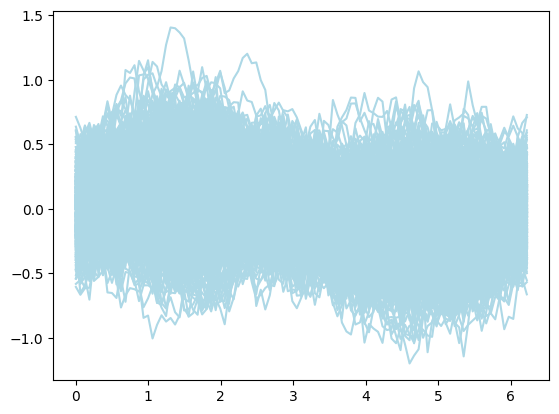

In [32]:
plt.plot(x_array, samples_mala_list[0].get_samples()["theta"].T, color="lightblue")
plt.show()

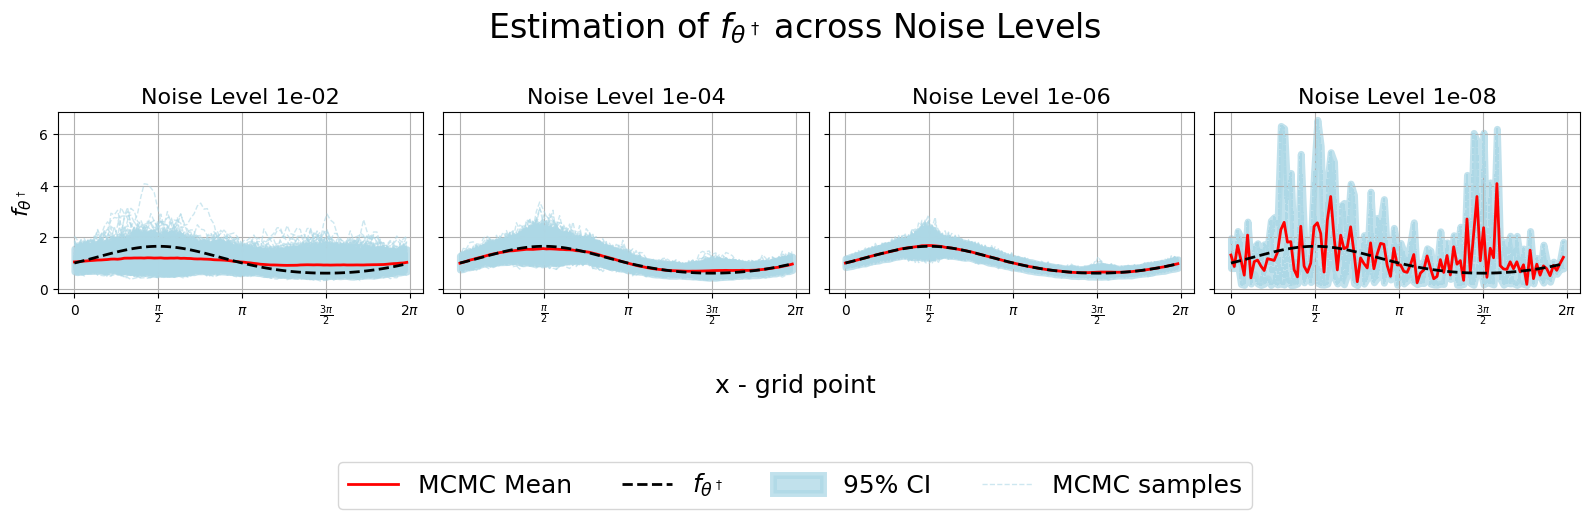

In [33]:
x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
q = jnp.array([0.025, 0.975])

num_levels = len(results_list)  # number of noise levels

fig, axes = plt.subplots(
    1,  # single row
    num_levels,
    figsize=(4 * num_levels, 4),
    sharex=True,
    sharey=True,
)

# Handle the case where there's only one noise level
if num_levels == 1:
    axes = [axes]

# Loop over noise levels (columns)
for col_idx, results in enumerate(samples_mala_list):
    ax = axes[col_idx]

    mcmc_samples = jnp.exp(results.get_samples()["theta"])

    # Plot individual ensemble members
    samples_handle = ax.plot(
        x_array,
        mcmc_samples.T,
        color="lightblue",
        linestyle="dashed",
        alpha=0.6,
        linewidth=1,
    )

    # Ensemble mean
    (sample_mean_handle,) = ax.plot(
        x_array,
        jnp.mean(mcmc_samples, axis=0),
        color="red",
        linewidth=2,
        label="ensemble mean",
    )

    (f0_handle,) = ax.plot(
        x_array,
        f0,
        color="black",
        label=r"$\theta^\dagger$",
        linestyle="dashed",
        linewidth=2,
    )

    # Quantiles
    quantiles = jnp.quantile(mcmc_samples, q, axis=0)
    fill_handle = ax.fill_between(
        x_array,
        quantiles[0],
        quantiles[1],
        color="lightblue",
        alpha=0.75,
        label="95% CI",
        linewidth=5,
    )

    # Set title for each subplot
    ax.set_title(f"Noise Level {noise_levels[col_idx]:.0e}", fontsize=16)
    ax.set_xticks([0, jnp.pi / 2, jnp.pi, 3 * jnp.pi / 2, 2 * jnp.pi])
    ax.set_xticklabels(
        ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    )
    ax.grid(True)

# Set ylabel for the single row
axes[0].set_ylabel(r"$f_{\theta^\dagger}$", fontsize=16)

fig.supxlabel("x - grid point", fontsize=18)

# Common legend
handles = [sample_mean_handle, f0_handle, fill_handle, samples_handle[0]]
labels = ["MCMC Mean", r"$f_{\theta^\dagger}$", "95% CI", "MCMC samples"]
fig.legend(
    handles, labels, loc="lower center", ncol=4, fontsize=18, bbox_to_anchor=(0.5, -0.3)
)

# Main title
fig.suptitle(r"Estimation of $f_{\theta^\dagger}$ across Noise Levels", fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

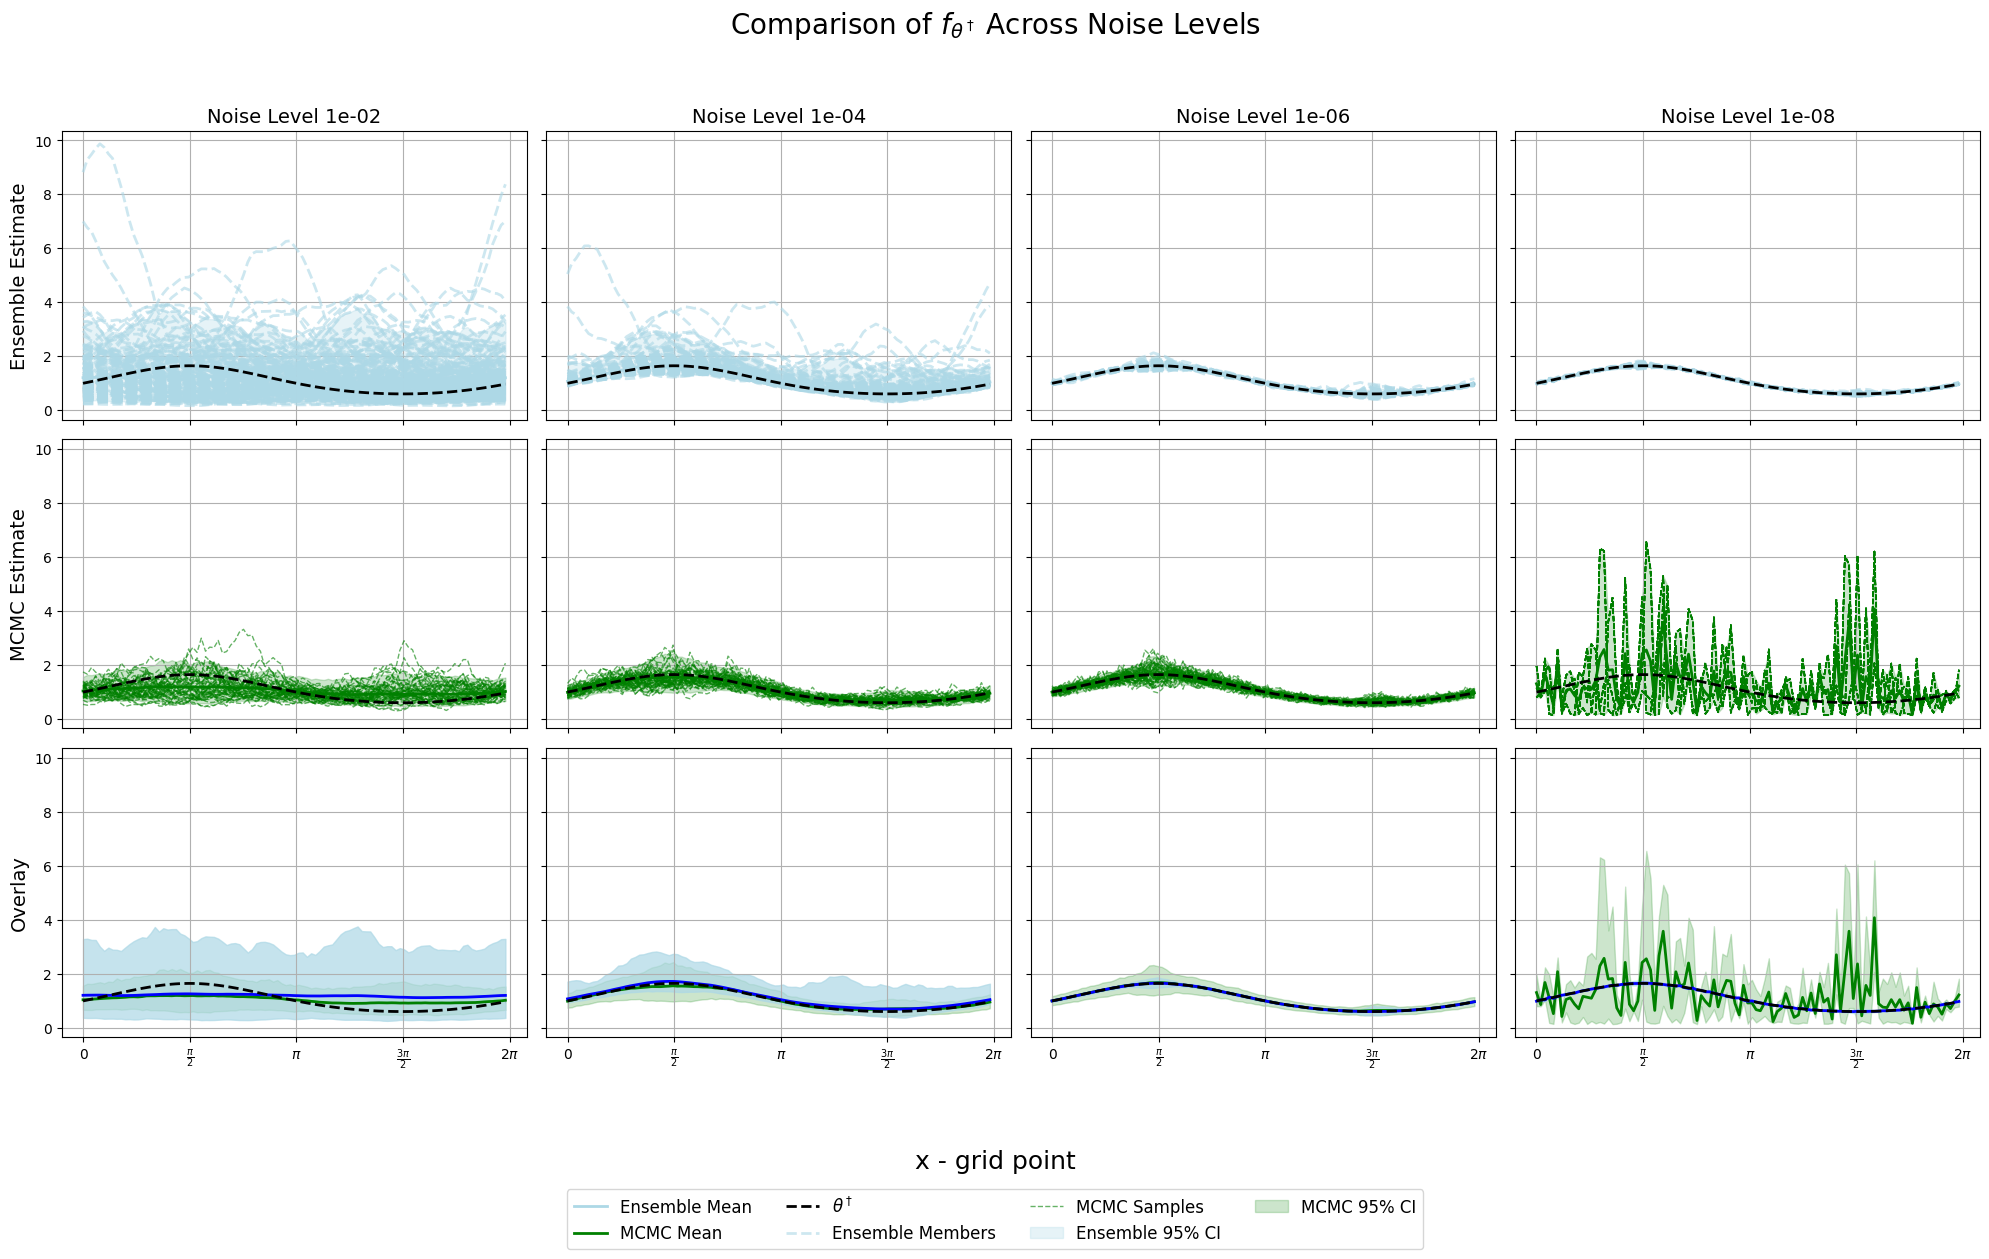

In [59]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
q = jnp.array([0.025, 0.975])
num_levels = len(results_list)

fig, axes = plt.subplots(
    3,  # 3 rows: Ensemble, MCMC, Overlay
    num_levels,
    figsize=(5 * num_levels, 12),
    sharex=True,
    sharey=True,
)

if num_levels == 1:
    axes = axes.reshape(3, 1)

for col_idx in range(num_levels):
    noise_level = noise_levels[col_idx]

    # ==== Row 0: Ensemble ====
    ax0 = axes[0, col_idx]
    ensemble_data = results_list[col_idx]["ensemble_history"][-1]

    ensemble_lines = ax0.plot(
        x_array,
        ensemble_data,
        color="lightblue",
        linestyle="dashed",
        alpha=0.6,
        linewidth=2,
    )
    (ensemble_mean_line,) = ax0.plot(
        x_array,
        jnp.mean(ensemble_data, axis=1),
        color="lightblue",
        linewidth=2,
        label="Ensemble Mean",
    )
    (f0_line0,) = ax0.plot(
        x_array,
        f0,
        color="black",
        linestyle="dashed",
        linewidth=2,
        label=r"$\theta^\dagger$",
    )
    quantiles_ens = jnp.quantile(ensemble_data, q, axis=1)
    ensemble_fill = ax0.fill_between(
        x_array,
        quantiles_ens[0],
        quantiles_ens[1],
        color="lightblue",
        alpha=0.3,
        label="Ensemble 95% CI",
    )
    ax0.set_title(f"Noise Level {noise_level:.0e}", fontsize=14)
    ax0.grid(True)

    # ==== Row 1: MCMC (after exponentiation) ====
    ax1 = axes[1, col_idx]
    mcmc_raw = samples_mala_list[col_idx].get_samples()["theta"]
    mcmc_samples = jnp.exp(mcmc_raw)  # <--- exponentiation

    random_idx = np.random.permutation(list(range(mcmc_samples.shape[0])))[:50]

    mcmc_thinned = mcmc_samples[random_idx, :]
    mcmc_lines = ax1.plot(
        x_array,
        mcmc_thinned.T,
        color="green",
        linestyle="dashed",
        alpha=0.6,
        linewidth=1,
    )
    (mcmc_mean_line,) = ax1.plot(
        x_array,
        jnp.mean(mcmc_samples, axis=0),
        color="green",
        linewidth=2,
        label="MCMC Mean",
    )
    (f0_line1,) = ax1.plot(
        x_array,
        f0,
        color="black",
        linestyle="dashed",
        linewidth=2,
        label=r"$\theta^\dagger$",
    )
    quantiles_mcmc = jnp.quantile(mcmc_samples, q, axis=0)
    mcmc_fill = ax1.fill_between(
        x_array,
        quantiles_mcmc[0],
        quantiles_mcmc[1],
        color="green",
        alpha=0.2,
        label="MCMC 95% CI",
    )
    ax1.grid(True)

    # ==== Row 2: Overlay ====
    ax2 = axes[2, col_idx]
    # MCMC

    ax2.plot(
        x_array,
        jnp.mean(mcmc_samples, axis=0),
        color="green",
        linewidth=2,
    )
    ax2.fill_between(
        x_array,
        quantiles_mcmc[0],
        quantiles_mcmc[1],
        color="green",
        alpha=0.2,
    )

    ax2.plot(
        x_array,
        jnp.mean(ensemble_data, axis=1),
        color="blue",
        linewidth=2,
    )
    ax2.fill_between(
        x_array,
        quantiles_ens[0],
        quantiles_ens[1],
        color="lightblue",
        alpha=0.7,
    )
    ax2.plot(
        x_array,
        f0,
        color="black",
        linestyle="dashed",
        linewidth=2,
    )
    ax2.grid(True)

# Labels
axes[0, 0].set_ylabel("Ensemble Estimate", fontsize=14)
axes[1, 0].set_ylabel("MCMC Estimate", fontsize=14)
axes[2, 0].set_ylabel("Overlay", fontsize=14)
# axes[2, 0].set_xlabel("x - grid point", fontsize=16, loc="center")

for ax in axes[2]:
    ax.set_xticks([0, jnp.pi / 2, jnp.pi, 3 * jnp.pi / 2, 2 * jnp.pi])
    ax.set_xticklabels(
        ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    )
fig.supxlabel("x - grid point", fontsize=18)
# Legend
handles = [
    ensemble_mean_line,
    mcmc_mean_line,
    f0_line0,
    ensemble_lines[0],
    mcmc_lines[0],
    ensemble_fill,
    mcmc_fill,
]
labels = [
    "Ensemble Mean",
    "MCMC Mean",
    r"$\theta^\dagger$",
    "Ensemble Members",
    "MCMC Samples",
    "Ensemble 95% CI",
    "MCMC 95% CI",
]
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=4,
    fontsize=12,
    bbox_to_anchor=(0.5, -0.06),
)

fig.suptitle(r"Comparison of $f_{\theta^\dagger}$ Across Noise Levels", fontsize=20)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()